## Sirius/LNLS - Scientific Computing Group
## Ptychography

This notebook contains an example on how reconstruct a synthetic ptychography dataset using sscCdi.

In [1]:
from skimage import data
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.colors import hsv_to_rgb, LogNorm
import scipy
import json
import sscCdi
import time
print(f'sscCdi version: {sscCdi.__version__}')

sscCdi version: 0.14.2


## 0. Generate synthetic data

First of all, we are going to describe several functions to generate our synthetic dataset. This is done by "simulating" the beamline forward operator. We will recover a complex object created by joining the classical "cameraman" picture as the amplitude and the "gravel" picture as the phase. Both images are extracted from the standard `skimage.data` module.

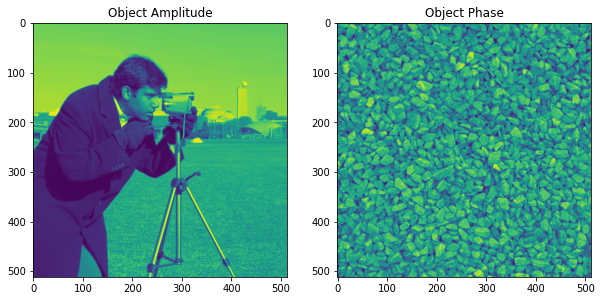

In [2]:
fig, ax = plt.subplots(1,2, figsize=(10,10))

ax[0].imshow(np.array(getattr(data, 'camera')()))
ax[0].set_title("Object Amplitude");

ax[1].imshow(np.array(getattr(data, 'gravel')()))
ax[1].set_title("Object Phase");

### 0.0. Some util functions used in the simulation

In [3]:
def create_2d_gaussian(N, M, sigma_x, sigma_y, mu_x=None, mu_y=None):
    """
    Creates a 2D Gaussian distribution matrix.

    Parameters:
    - N: Number of rows.
    - M: Number of columns.
    - sigma_x: Standard deviation in the x direction.
    - sigma_y: Standard deviation in the y direction.
    - mu_x: Mean in the x direction. Defaults to the center of the matrix if not provided.
    - mu_y: Mean in the y direction. Defaults to the center of the matrix if not provided.

    Returns:
    A 2D array representing the Gaussian distribution.
    """
    if mu_x is None:
        mu_x = N / 2
    if mu_y is None:
        mu_y = M / 2

    x = np.linspace(0, N-1, N)
    y = np.linspace(0, M-1, M)
    x, y = np.meshgrid(x, y)

    gaussian = np.exp(-(((x - mu_x) ** 2) / (2 * sigma_x ** 2) + ((y - mu_y) ** 2) / (2 * sigma_y ** 2)))
    return gaussian


def create_2d_disk(N,M,sigma):
    x = np.linspace(0, N-1, N)
    y = np.linspace(0, M-1, M)
    x, y = np.meshgrid(x, y)
    disk = np.where((x-N/2)**2 + (y-M/2)**2 <= (sigma)**2, 1, 0)
    return disk


def apply_random_shifts_to_positions(pos_x, pos_y, range_x, range_y, mu=0, sigma_x=2, sigma_y=2, type='gaussian'):
    if type == 'gaussian':
        deltaX = np.random.normal(mu, sigma, pos_x.shape)
        deltaY = np.random.normal(mu, sigma, pos_y.shape) 
        
        # Apply a different delta to each X and Y
        new_positions_x = range_x[0] +  ((pos_x + deltaX)% range_x[1])
        new_positions_y = range_y[0] +  ((pos_y + deltaY)% range_y[1])
        
    elif type == 'random':
        deltaX = np.round(sigma * np.random.rand(*pos_x.shape))
        deltaY = np.round(sigma * np.random.rand(*pos_y.shape))
        
         # Apply a different delta to each X and Y
        new_positions_x = range_x[0] +  ((pos_x + deltaX)% range_x[1])
        new_positions_y = range_y[0] +  ((pos_y + deltaY)% range_y[1])
    elif type == "uniform":
        deltaX = np.round(np.random.uniform(-sigma_x,sigma_x,pos_x.shape))
        deltaY = np.round(np.random.uniform(-sigma_y,sigma_y,pos_y.shape))
        
        # Apply a different delta to each X and Y
        new_positions_x = pos_x + deltaX
        new_positions_y = pos_y + deltaY
   

    # Normalize to start from 0
    # new_positions_x -= np.min(new_positions_x)
    # new_positions_y -= np.min(new_positions_y)

    return new_positions_x, new_positions_y


def get_positions_array(frame_shape,range_x, range_y, nx, ny, random_positions=True, plot=True):
    y_pxls = np.linspace(range_y[0], range_y[1], ny)
    x_pxls = np.linspace(range_x[0], range_x[1], nx)
    
    pos_y,pos_x = np.meshgrid(y_pxls,x_pxls)
    
    # sigma_x = np.sqrt((frame_shape[0]/180.0)) #*2
    # sigma_y = np.sqrt((frame_shape[1]/180.0)) #*2 
    sigma_x = (range_x[1] - range_x[0])/(2*nx)
    sigma_y = (range_y[1] - range_y[0])/(2*ny)
    
    if random_positions == True:
       pos_x,pos_y = apply_random_shifts_to_positions(pos_x, pos_y, range_x, range_y,  sigma_x=sigma_x, sigma_y=sigma_y, type="uniform")
    
    positions = np.vstack((np.array(pos_x.flatten()) ,np.array(pos_y.flatten()))).T
    
    if plot: # Plot positions map
        figure, ax = plt.subplots(dpi=100)
        ax.plot(positions[:,0],positions[:,1],'.',label='Original',color='black')
        ax.set_title('Positions') 
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_aspect('equal')
    return positions


def create_hsv_wheel_image(size=256):
    """Create an HSV color wheel image."""
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    X, Y = np.meshgrid(x, y)
    Z = X + 1j * Y  # Create complex plane

    # Amplitude is the distance from the center
    Amplitude = np.abs(Z)
    
    # Phase is the angle (in radians) from the positive real axis
    Phase = np.angle(Z)

    # Create the complex image with varying amplitude and phase
    ComplexImg = np.exp(1j * Phase)
    
    # Normalize amplitude to the maximum distance (which is sqrt(2) for this range)
    ComplexImg *= Amplitude / np.max(Amplitude)

    # Convert the complex image to RGB using the provided function
    RGB_image = sscCdi.misc.convert_complex_to_RGB(ComplexImg, bias=0.001)

    # Mask out the region outside the unit circle (optional)
    mask = Amplitude <= 1
    RGB_image[~mask] = 1  # Set to white or any other background color

    return RGB_image


def interpolate_image(image, new_shape, interpolation_factor = 0.5):
    """
    Interpolates a single image to a new size new_shape using bicubic interpolation.
    
    Parameters:
    - image: numpy array of shape (H, W), the original image.
    - new_shape: int, the size of the output image (Hnew, Wnew).
    
    Returns:
    - interpolated_image: numpy array of shape new_shape, the resized image.
    """
    
    # define zoom factor
    zoom_factor_h = new_shape[0]/image.shape[0]
    zoom_factor_w = new_shape[1]/image.shape[1]
    
    # resize image to have new_shape 
    image_resized = scipy.ndimage.zoom(image, (zoom_factor_h, zoom_factor_w), order = 3)
    
    return image_resized

### 0.1. The main generate function

In [4]:
def generate_ptychography_dataset(obj, probe, positions, add_position_errors=False, plot=False):

    #TODO: add invalid points to diffraction pattern

    if obj.ndim != 2 or probe.ndim != 2:
        raise ValueError("obj and probe must be 2D arrays.")

    """ Create Probe """
    probe_size_y, probe_size_x = probe.shape

    if probe_size_y > obj.shape[0] or probe_size_x > obj.shape[1]:
        raise ValueError("Probe must be smaller than the object.")

    pos_x,pos_y = positions[:,0], positions[:,1] # (N,2) array, x and y positions

    print('Model object: ',obj.shape)
    print('Probe: ',probe.shape)
    print('Positions: ',positions.shape)
    
    diff_patterns = np.empty((positions.shape[0],probe_size_y,probe_size_x),dtype=float)
    probe_story_mask = np.zeros_like(obj,dtype=float)
    for i, position in enumerate(positions):
    
        px,py = np.round(position) # round to nearest integer
        px = int(px)
        py = int(py)

        """ Exit wave-field """
        wavefront = obj[py:py+probe_size_y,px:px+probe_size_x]*probe
        probe_story_mask[py:py+probe_size_y,px:px+probe_size_x] += np.abs(probe)
    
        """ Prpagation and Measurement """
        diff_patterns[i] = np.absolute(np.fft.fftshift(np.fft.fft2(wavefront)))**2
    
    positions = np.hstack((np.array([pos_x]).T ,np.array([pos_y]).T)) # adjust positions format for proper input
    position_errors = None
    
    # fix positions 
    positions = np.roll(positions, shift=1, axis=1)

    probe_story_mask = np.where(probe_story_mask>0,1,0)

    if plot:
        fig, ax = plt.subplots(1, 5, dpi=150, figsize=(18, 5), gridspec_kw={'width_ratios': [1, 1, 1, 1, 0.5]})

        # Plot positions
        ax[0].plot(positions[:, 0], positions[:, 1], '.', label='Original', color='black')
        ax[0].set_title('Positions')
        ax[0].set_xlabel('X')
        ax[0].set_ylabel('Y')
        ax[0].set_aspect('equal')

        # Plot amplitude and phase for the object
        ax[1].set_title('Amplitude')
        amp_img = ax[1].imshow(np.abs(obj),cmap='viridis')
        # ax[1].imshow(probe_story_mask, alpha=0.3)
        fig.colorbar(amp_img, ax=ax[1], orientation='horizontal', fraction=0.046, pad=0.04)

        ax[2].set_title('Phase')
        phase_img = ax[2].imshow(np.angle(obj), cmap='viridis')
        ax[2].imshow(probe_story_mask, alpha=0.3)
        fig.colorbar(phase_img, ax=ax[2], orientation='horizontal', fraction=0.046, pad=0.04)

        # Plot amplitude and phase for the probe
        ax[3].set_title('Probe')
        probe_rgb_img = ax[3].imshow(sscCdi.misc.convert_complex_to_RGB(probe))

        # Create the HSV color wheel
        hsv_wheel = create_hsv_wheel_image(size=256)
        ax[4].imshow(hsv_wheel)
        ax[4].set_title('')

        # # Hide the axes for the color wheel plot
        ax[4].axis('off')

        ax[1].axis('off')
        ax[2].axis('off')
        ax[3].axis('off')

        # Parameters for placing the tick labels
        radius = 128  # Radius of the color wheel
        center = (128, 128)  # Center of the color wheel

        # Define the tick angles and corresponding labels
        tick_angles = [0, np.pi/2, np.pi, 3*np.pi/2]
        tick_labels = ['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$']

        # Convert the angles to Cartesian coordinates for placing the labels
        for angle, label in zip(tick_angles, tick_labels):
            x = center[0] + (15+radius) * np.cos(angle)
            y = center[1] + (15+radius) * np.sin(angle)
            ax[4].text(x, y, label, fontsize=10, ha='center', va='center')

        # # Add a circular boundary to indicate the extent of the color wheel
        circle = plt.Circle(center, radius, color='black', fill=False, linestyle='-', linewidth=0.5)
        ax[4].add_patch(circle)

        plt.tight_layout()
        plt.show()

    return diff_patterns, positions, position_errors, probe_story_mask



### 0.2. ... And now we use it

In [5]:
# loop from all values in range (1*128, 2*128, ... , 24*128) and generate the dataset for 
# each of these interpolated sizes 
interp_factor = 1

# define dataset parameters 
# probe_pixel_size = 1.25156e-6 # meters
energy = 10 # keV
distance = 15 # meters 
wavelength = sscCdi.misc.wavelength_meters_from_energy_keV(energy) # meters
propagation_distance = 0*2e-2 # meters
detector_pixel_size = 55e-6
N = 64*interp_factor
probe_pixel_size = wavelength*distance/(N*detector_pixel_size)
print('Probe pixel size: ',probe_pixel_size)

# create probe
sigma = 30*N/128 # 30*N/128
probe = create_2d_gaussian(N, N, sigma, sigma, mu_x=None, mu_y=None)
disk = create_2d_disk(N, N, int(np.round(N/3.8))) # N/3
probe = probe*disk
probe[probe>0] = 1
probe = probe/np.max(probe)
probe_phase = (probe - np.min(probe)) * (2 * np.pi) / (np.max(probe) - np.min(probe)) - np.pi
probe = probe*np.exp(1j*probe_phase*0)
# probe = sscCdi.processing.propagation.fresnel_propagator_cone_beam(probe,wavelength,probe_pixel_size,propagation_distance)

# create object
obj_amplitude =  getattr(data, 'camera')() 
obj_phase = getattr(data, 'gravel')()
obj_amplitude =  interpolate_image(obj_amplitude, (int(np.round(3*N)), int(np.round(3*N)))) 
obj_phase =  interpolate_image(obj_phase, (int(np.round(3*N)), int(np.round(3*N))))          
obj_phase = obj_phase/np.max(obj_phase)

# debug 
print("obj_amplitude.shape (before padding) =", obj_amplitude.shape)
print("obj_phase.shape (before padding) =", obj_phase.shape)

# pad images 
N2 = obj_phase.shape[0]
pad = (int(1.5*N2)-N2)/2
obj_amplitude = np.pad(obj_amplitude,((int(pad),int(pad)),(int(pad),int(pad))),mode='constant',constant_values=0)
obj_phase = np.pad(obj_phase,((int(pad),int(pad)),(int(pad),int(pad))),mode='constant',constant_values=0)

# normalize images
obj_amplitude = obj_amplitude/obj_amplitude.max()
obj_phase_normalized = (obj_phase - np.min(obj_phase)) * (2*np.pi) / (np.max(obj_phase) - np.min(obj_phase)) - np.pi
obj_phase_normalized = obj_phase_normalized/2
obj = obj_amplitude*np.exp(1j*obj_phase_normalized)

# debug 
print("N=", N)
print("obj.shape = ", obj.shape)
print("probe.shape =", probe.shape)
print("pad =", pad)


# define range of positions 
range_x = [pad//4, 3*N*1.1]     # pad//4
range_y = [pad//4, 3*N*1.1]  # pad//4
nx = 12 # 12
ny = 12 # 12
positions = np.round(get_positions_array(probe.shape, range_x, range_y, nx, ny, random_positions=True, plot=False))

# create metadata dictionary
metadata = {}
metadata['energy'] = energy
metadata['distance'] = distance
metadata['wavelength'] = wavelength
metadata['probe_pixel_size'] = probe_pixel_size
metadata['detector_pixel_size'] = detector_pixel_size   
metadata['propagation_distance'] = propagation_distance
metadata['probesize'] = probe.shape
metadata['objectsize'] = obj.shape

# generate data 
diff_patterns, positions, positions_errors, probe_story_mask = generate_ptychography_dataset(obj, probe, positions)
metadata['datasize'] = diff_patterns.shape

Probe pixel size:  5.283417502253238e-07
obj_amplitude.shape (before padding) = (192, 192)
obj_phase.shape (before padding) = (192, 192)
N= 64
obj.shape =  (288, 288)
probe.shape = (64, 64)
pad = 48.0
Model object:  (288, 288)
Probe:  (64, 64)
Positions:  (144, 2)


### 0.3. Adding error in the positions

If we want, we can simulate a random error at each scan position.

In [39]:
# add small error in the position. If wind = 0, no error is added 
wind = 0
wrong_positions = positions + np.random.randint(low=-wind, high=wind+1, size = positions.shape)

original_positions = positions.copy()

### 0.4. Visualize

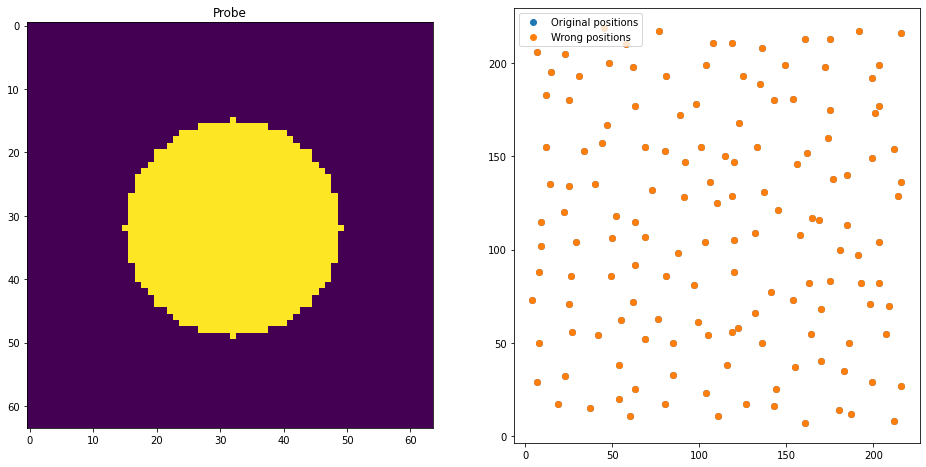

In [40]:
fig, ax = plt.subplots(1,2, figsize = (16,8))
ax[0].imshow(np.abs(probe))
ax[0].set_title("Probe")
 
ax[1].scatter(positions[:,0], positions[:,1], label="Original positions");
ax[1].scatter(wrong_positions[:,0], wrong_positions[:,1], label="Wrong positions");
plt.legend()

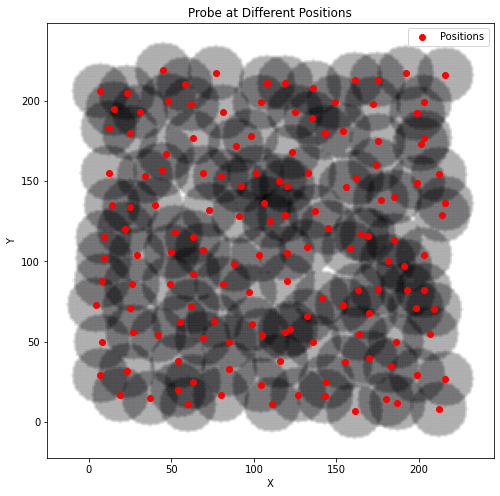

In [41]:
# create data using the original positions
size = 20
# Create figure
fig, ax = plt.subplots(figsize=(8,8))

# Overlay the probe at each position
for x, y in positions:
    nonzero_x, nonzero_y = np.where(np.abs(probe) > 0)  # Mask for nonzero values
    ax.scatter(x + nonzero_x - probe.shape[1]//2, y + nonzero_y -probe.shape[1]//2, 
               c=np.abs(probe)[nonzero_x, nonzero_y], cmap="inferno", s=10, alpha=0.05)

# Highlight positions
ax.scatter(positions[:, 0], positions[:, 1], color='red', marker='o', label="Positions")

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Probe at Different Positions")
ax.legend()
plt.show()

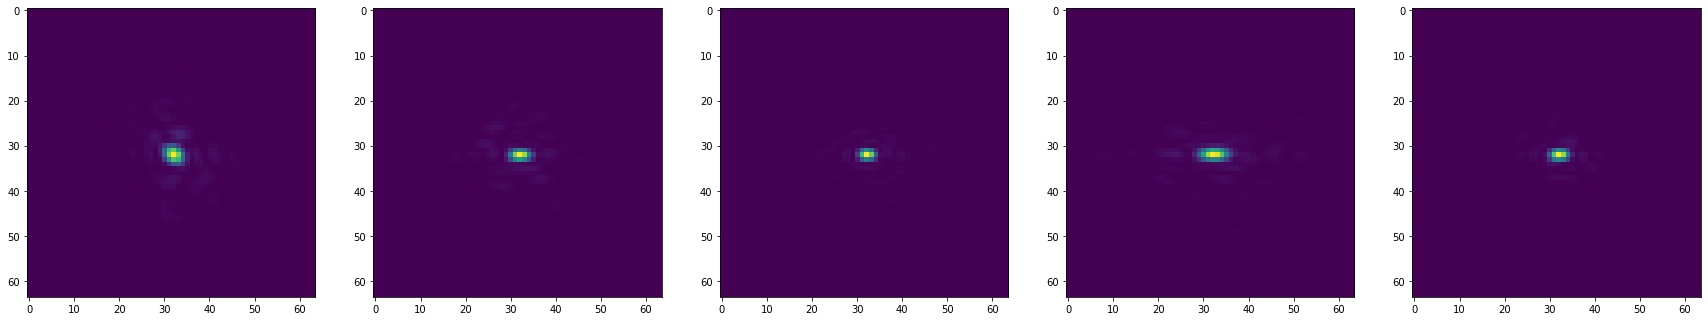

In [42]:
# first 10 diff patterns
fig, ax = plt.subplots(1,5, figsize=(30,6))
ax[0].imshow(diff_patterns[0]);
ax[1].imshow(diff_patterns[1]);
ax[2].imshow(diff_patterns[2]);
ax[3].imshow(diff_patterns[3]);
ax[4].imshow(diff_patterns[4]);


## 1. Pytchography reconstruction

In [43]:
initial_probe = None
initial_obj = None 
ngpus = 1

# common parameters for algorithms
niter =3000
batch = 128 

### 1.1. Define the dictionary of parameters

In [44]:
# ssc-cdi
input_dict = {
    "hdf5_output": './output.h5', # path to hdf5 file to contain all outputs
    'CPUs': 32,  # number of cpus to use in parallel execution    
    'GPUs': list(range(int(ngpus))), # list of numbers (e.g. [0,1,2]) containg the number of the GPUs
    "fresnel_regime": False,
    'energy': 10, # 6, # energy in keV
    'detector_distance': 15,  # 13, # meters
    'distance_sample_focus': 0, # float. Distance in meters between sample and focus or pinhole. This distance is used to propagated the probe prior to application of the probe support. 
    'detector_pixel_size': 55e-6, # meters
    'binning': 1, # how many times to bin data. Must be even number. if 1, no binning occurs.
    'position_rotation': 0, # angle in radians. Rotation applied to the positions for correcting angle between detector and probe transverse coordinates
    'object_padding': 20, # pixels. Number of pixels to add around the object matrix
    'incoherent_modes': 1, # int. Number of incoherent modes to use
    'probe_support': {"type": "circular",  "radius":  int(int(N)*(64/128)),  "center_y": 0, "center_x": 0} , # support to be applied to the probe matrix after probe update. Options are:
                                                                                           # - {"type": "circular",  "radius": 300,  "center_y": 0, "center_x": 0} (0,0) is the center of the image
                                                                                           # - {"type": "cross",  "center_width": 300,  "cross_width": 0, "border_padding": 0} 
                                                                                           # - {"type": "array",  "data": myArray}
    "initial_obj": {"obj": 'random'},     # 2d array. Initial guess for the object. Options are:
                                          # - {"obj": my2darray}, numpy array 
                                          # - {"obj": 'path/to/numpyFile.npy'}, path to .npy, 
                                          # - {"obj": 'path/to/hdf5File.h5'}, path to .hdf5 of previous recon containing the reconstructed object in 'recon/object'
                                          # - {"obj": 'random'}, random matrix with values between 0 and 1
                                          # - {"obj": 'constant'}, constant matrix of 1s
    "initial_probe": {"probe": 'inverse'},   # 2d array. Initial guess for the probe. Options are:
                                             # - {"probe": my2darray}, numpy array 
                                             # - {"probe": 'path/to/numpyFile.npy'}, path to .npy, 
                                             # - {"probe": 'path/to/hdf5File.h5'}, path to .hdf5 of previous recon containing the reconstructed object in 'recon/object'
                                             # - {"probe": 'random'}, random matrix with values between 0 and 1
                                             # - {"probe": 'constant'}, constant matrix of 1s
                                             # - {"probe": 'inverse'}, matrix of the Inverse Fourier Transform of the mean of DPs.
                                             # - {"probe": 'circular', "radius": 100, "distance":0},  circular mask with a pixel of "radius". If a distance (in meters) is given, it propagated the round probe using the ASM method.
}


input_dict['algorithms'] = {'1':{ 'name': 'RAAR',                       
                                'iterations': niter,
                                'step_object': 0.25, 
                                'step_probe': 0.1,
                                'regularization_object': 0.5,
                                'regularization_probe': 0.5,
                                'momentum_obj': 0.0,                 
                                'momentum_probe': 0.0,              
                                'position_correction':0,            # 0: no correction. N: performs correction every N iterations
                                'beta':1,                           # beta RAAR parameter
                                'batch':128                         # per GPU batchsize  
                        },  
}

                            
                    

### 1.2. Run! 

Data shape: (144, 64, 64)
Estimated size for 144 DPs of type float32: 0.00 GBs
Detector pixel size = 55.00 um
Energy = 10 keV
Wavelength = 0.124 nm
Object pixel = 528.34 nm


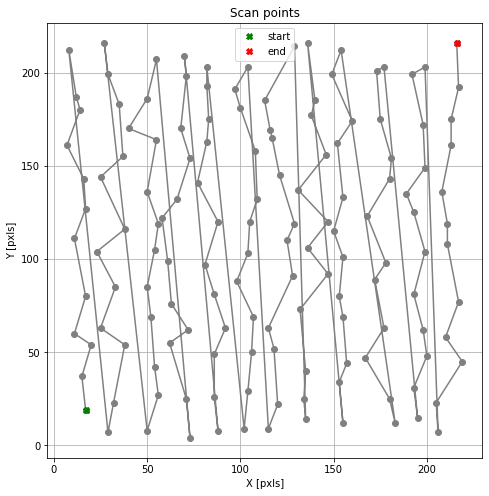

Object shape: (300, 303)
Creating output hdf5 file...
Creating initial probe of type:  inverse
Probe shape (64,64) with 1 incoherent mode(s)
Creating initial object of type:  random
Object shape: (300, 303) with dtype: complex64
Plotting initial guesses...


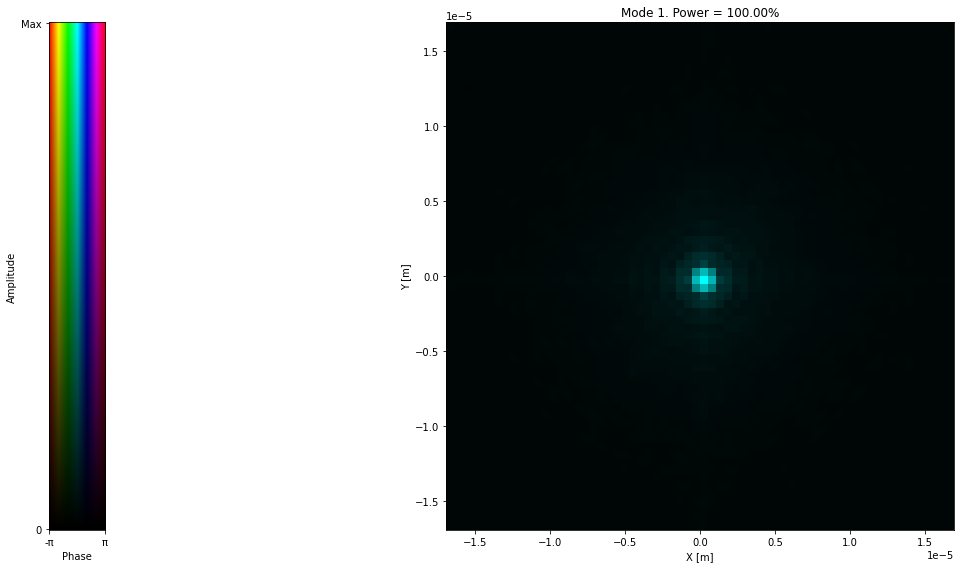

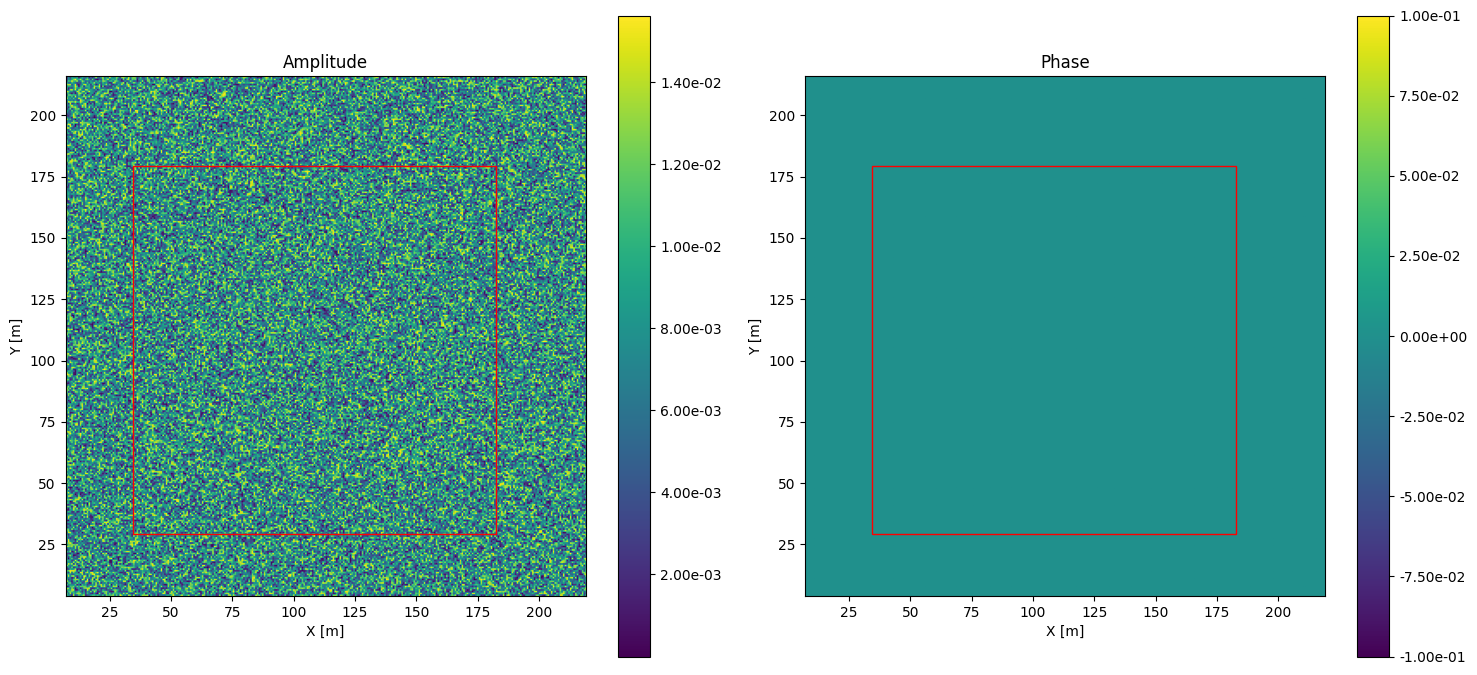

Setting probe support...


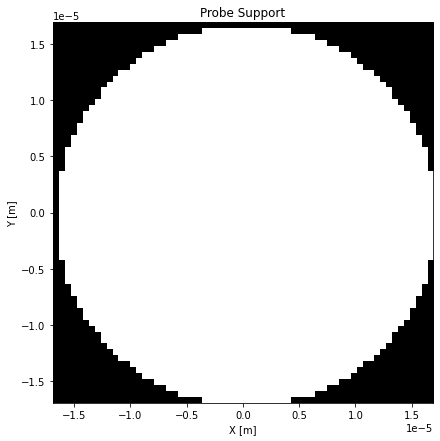

Distance between sample and focus: 0.0mm. Corresponding Fresnel number: 0
Total datapack size: 0.00 GBs
Starting ptychography... using 1 GPUs [0] and 32 CPUs
Calling 3000 iterations of RAAR algorithm...
%[12:14:01:915929] : [info] [thread 3658026] Starting RAAR - Probe: (64,64), Object: (300,303), Positions: 144, Batches: 128, Iterations: 3000
----------------------------------------------------------------------
pos_offx,y = (0.000000, 0.000000) 
pos_offx,y = (-1.000000, -1.000000) 
pos_offx,y = (-1.000000, 0.000000) 
pos_offx,y = (-1.000000, 1.000000) 
pos_offx,y = (0.000000, -1.000000) 
pos_offx,y = (0.000000, 1.000000) 
pos_offx,y = (1.000000, -1.000000) 
pos_offx,y = (1.000000, 0.000000) 
pos_offx,y = (1.000000, 1.000000) 
%[12:14:01:918883] : [info] [thread 3658026] Starting RAAR iteration.
%[12:14:01:921791] : [info] [thread 3658026] iter 0/3000 rfactor: 7665.661, llk = -600850200, mse = 29972.053
%[12:14:01:930663] : [info] [thread 3658026] iter 10/3000 rfactor: 7317.612, llk =

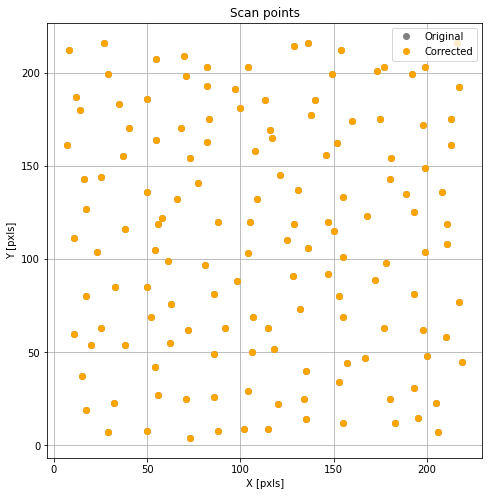

Plotting final object and probe...


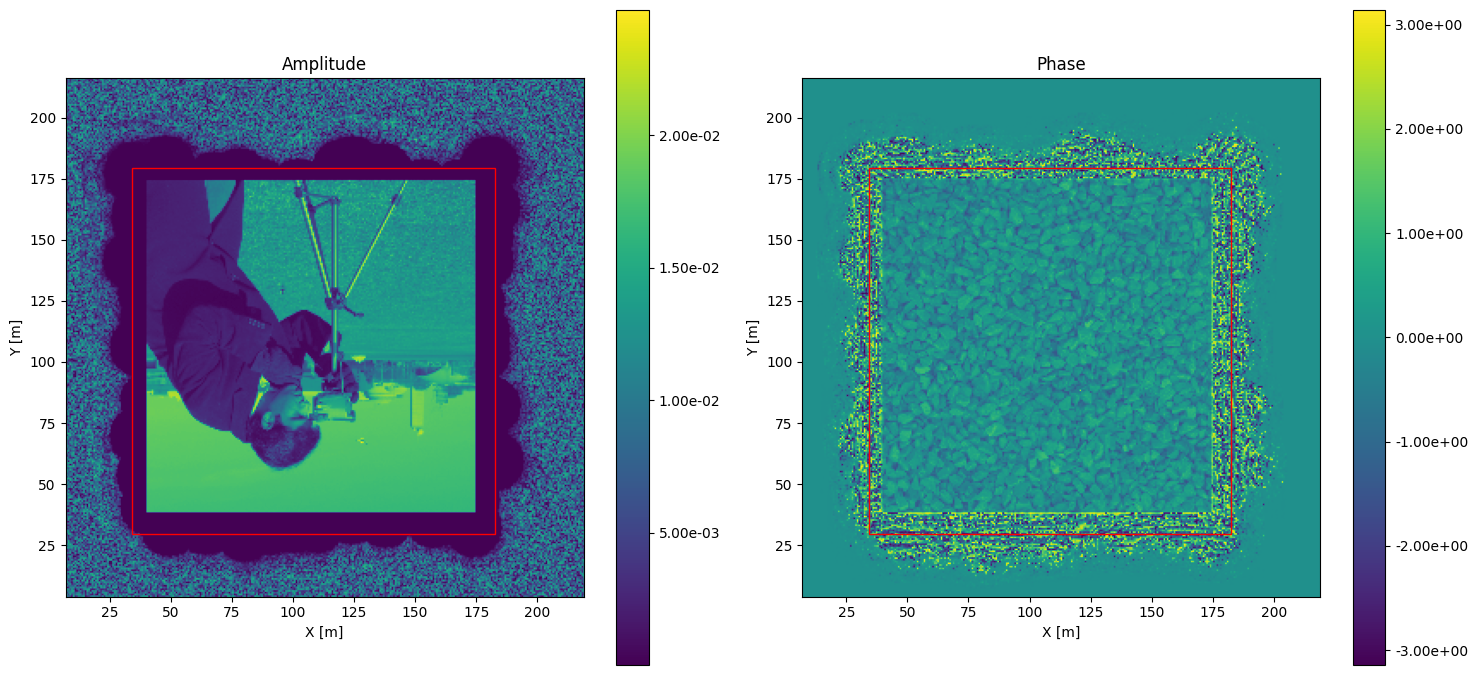

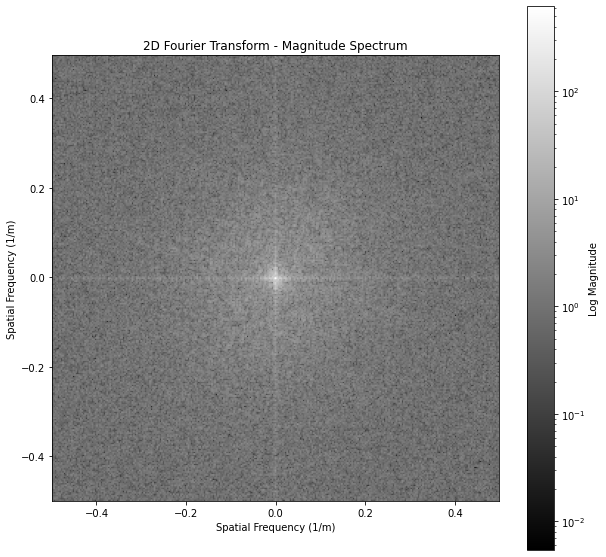

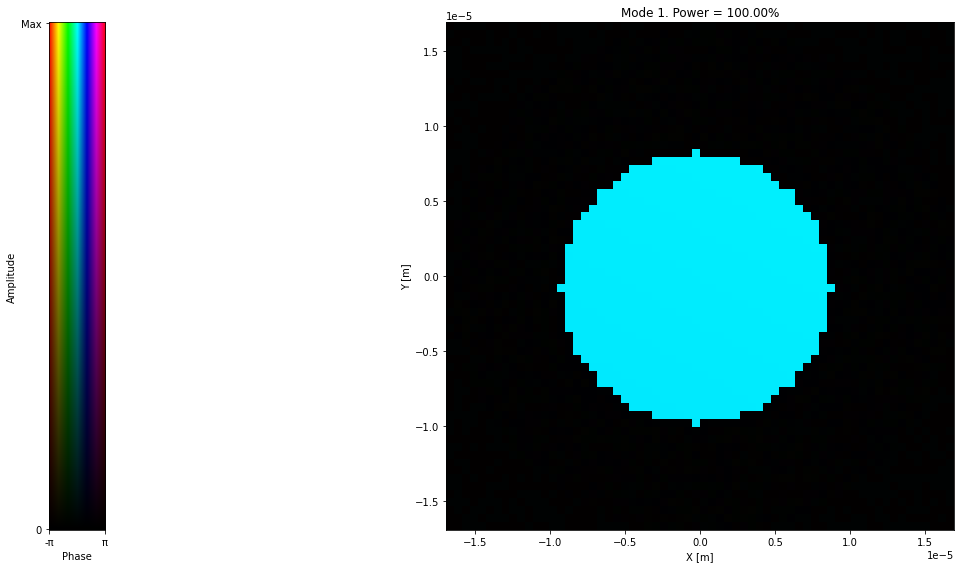

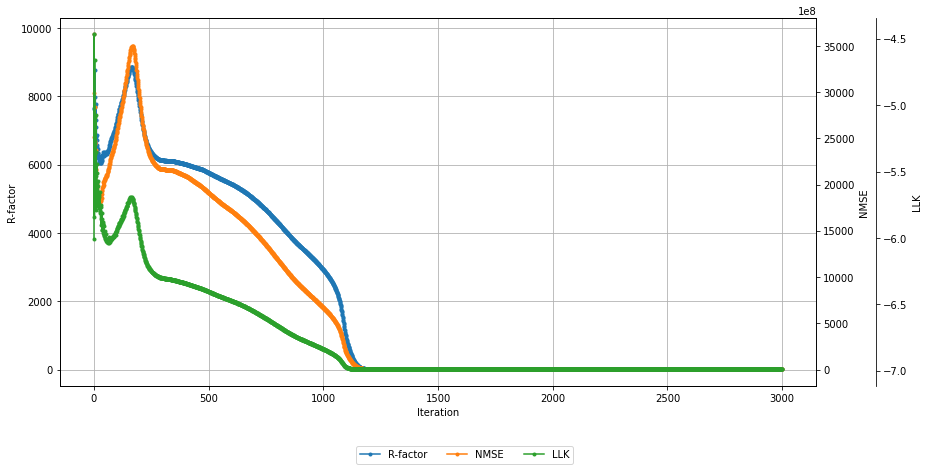

Saving output hdf5 file... 
Results saved at:  ./output.h5
Elapsed time for PIE(sscCdi): 5.216038227081299 sec


In [45]:
# run 
tic = time.time()
recon_obj, recon_probe,  recon_positions, output_dict, recon_error = sscCdi.call_ptychography(input_dict, diff_patterns, wrong_positions, initial_obj=initial_obj, initial_probe=initial_probe)
toc = time.time() - tic
print('Elapsed time for PIE(sscCdi): {} sec'.format(toc))

## 2. Check corrected positions

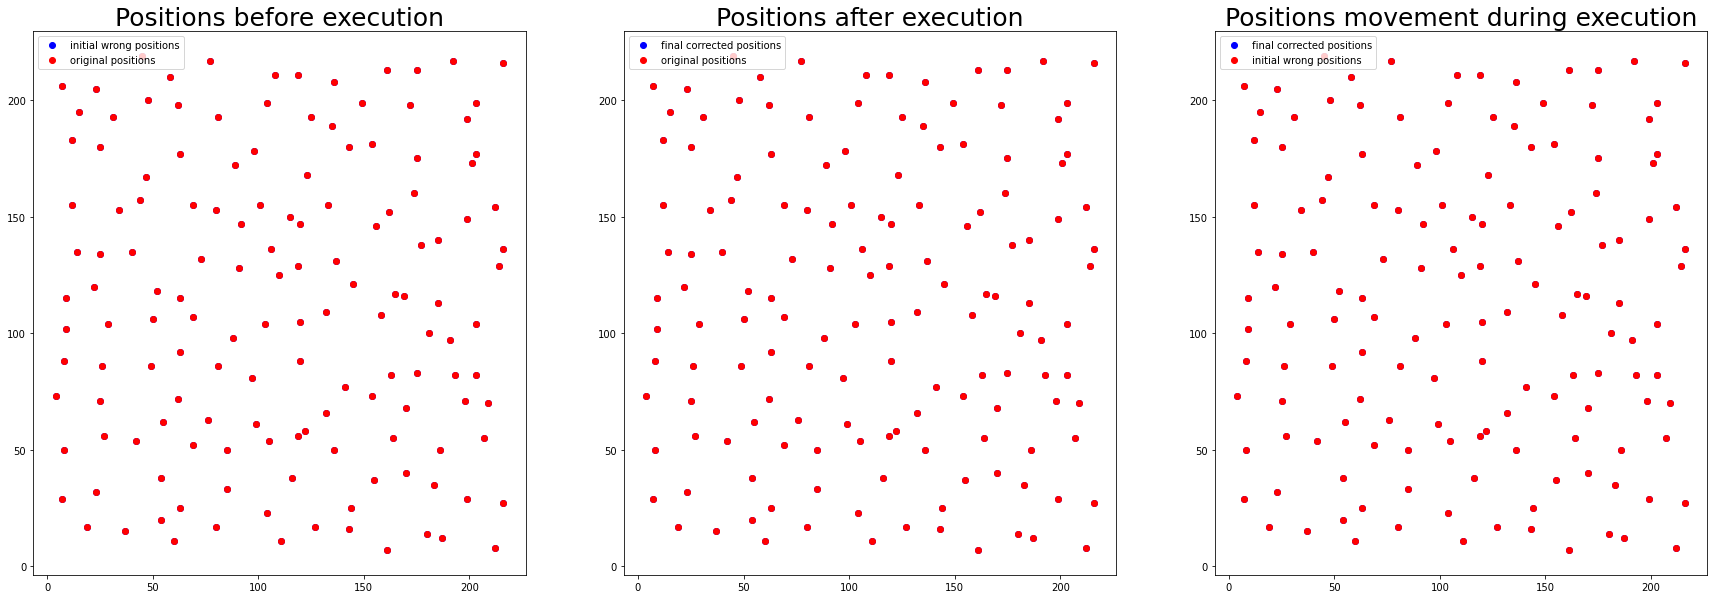

In [46]:
data_pos  = []
fig, axs = plt.subplots(1,3,figsize = (30,10))
axs[0].plot(wrong_positions[:,0],wrong_positions[:,1],'bo', label="initial wrong positions")
axs[0].plot(original_positions[:,0], original_positions[:,1], 'ro', label='original positions')
axs[0].legend()
axs[0].set_title("Positions before execution",fontsize = 25)

axs[1].plot(recon_positions[:,0],recon_positions[:,1],'bo', label="final corrected positions")
axs[1].plot(positions[:,0], positions[:,1], 'ro', label='original positions')
axs[1].legend()
axs[1].set_title("Positions after execution",fontsize = 25)

axs[2].plot(recon_positions[:,0], recon_positions[:,1],'bo', label="final corrected positions")
axs[2].plot(wrong_positions[:,0], wrong_positions[:,1], 'ro', label='initial wrong positions')
axs[2].legend()
axs[2].set_title("Positions movement during execution",fontsize = 25)

plt.show()